## libs

In [1]:
# python utils
import itertools
import inspect
import random
import pickle
from multiprocessing.dummy import Pool
import dill

# pre-processing and exploring data
import numpy as np
from sklearn.model_selection import StratifiedKFold
import statistics
from sklearn.preprocessing import StandardScaler
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# viz
import matplotlib.pyplot as plt
font = {'size'   : 15}
plt.rc('font', **font)

# model building
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data
from keras.losses import mean_squared_error

Using TensorFlow backend.


## Import Data

In [2]:
X_data = pd.read_csv("dataset.csv")

In [3]:
X_data

,n_rows,moving_avg_7d_n_rows,null_values_ratio,moving_avg_7d_null_values_ratio,max_string_length,moving_avg_7d_max_string_length,min_string_length,moving_avg_7d_min_string_length,avg_string_length,moving_avg_7d_avg_string_length,max_numeric,moving_avg_7d_max_numeric,min_numeric,moving_avg_7d_min_numeric,avg_numeric,moving_avg_7d_avg_numeric,date
0,40483,40483.0000,0.4091,0.4091,2894,2894.0000,1,1,35.4610,35.4610,1515413428144,1515413428144.0000,1,1.0000,194009593670.2281,194009593670.2281,2018-01-01
1,101110,70796.5000,0.4172,0.4131,2902,2898.0000,1,1,35.6261,35.5435,1517500687669,1516457057906.5000,1,1.0000,194058754764.6873,194034174217.4578,2018-01-02
2,121895,87829.3333,0.4165,0.4143,2894,2896.6667,1,1,35.7299,35.6057,1515765249688,1516226455167.0000,1,1.0000,194083433843.4540,194050594092.7899,2018-01-03
3,115572,94765.0000,0.4179,0.4152,3152,2960.5000,1,1,35.6451,35.6155,1515268023692,1515986847298.2500,1,1.0000,194092959578.1097,194061185464.1198,2018-01-04
4,106311,97074.2000,0.4169,0.4155,3149,2998.2000,1,1,35.8557,35.6635,1519491276563,1516687733151.2000,1,1.0000,194113016050.7653,194071551581.4489,2018-01-05
5,84731,95017.0000,0.4064,0.4140,2844,2972.5000,1,1,34.9761,35.5490,1516476968114,1516652605645.0000,1,1.0000,194118628372.6128,194079397713.3096,2018-01-06
6,92048,94592.8571,0.4115,0.4136,3213,3006.8571,1,1,34.7605,35.4363,1516559284082,1516639273993.1428,1,1.0000,194140010017.3358,194088056613.8848,2018-01-07
7,125830,106785.2857,0.4201,0.4152,3213,3052.4286,1,1,35.0782,35.3817,1515624167162,1516669379567.1428,1,1.0000,194168336844.4063,194110734210.1959,2018-01-08
8,130842,111032.7143,0.4178,0.4153,3182,3092.4286,1,1,35.2295,35.3250,1516947049720,1516590288431.5715,1,1.0000,194199910702.8933,194130899344.2253,2018-01-09
9,123299,111233.2857,0.4178,0.4155,2940,3099.0000,1,1,35.3534,35.2712,1517503912598,1516838668847.2856,1,1.0000,194214190205.7936,194149578824.5596,2018-01-10


## Preprocessing Data

In [4]:
# to pandas df
X_data = X_data.drop("date", 1)
X_data.head(10)

,n_rows,moving_avg_7d_n_rows,null_values_ratio,moving_avg_7d_null_values_ratio,max_string_length,moving_avg_7d_max_string_length,min_string_length,moving_avg_7d_min_string_length,avg_string_length,moving_avg_7d_avg_string_length,max_numeric,moving_avg_7d_max_numeric,min_numeric,moving_avg_7d_min_numeric,avg_numeric,moving_avg_7d_avg_numeric
0,40483,40483.0000,0.4091,0.4091,2894,2894.0000,1,1,35.4610,35.4610,1515413428144,1515413428144.0000,1,1.0000,194009593670.2281,194009593670.2281
1,101110,70796.5000,0.4172,0.4131,2902,2898.0000,1,1,35.6261,35.5435,1517500687669,1516457057906.5000,1,1.0000,194058754764.6873,194034174217.4578
2,121895,87829.3333,0.4165,0.4143,2894,2896.6667,1,1,35.7299,35.6057,1515765249688,1516226455167.0000,1,1.0000,194083433843.4540,194050594092.7899
3,115572,94765.0000,0.4179,0.4152,3152,2960.5000,1,1,35.6451,35.6155,1515268023692,1515986847298.2500,1,1.0000,194092959578.1097,194061185464.1198
4,106311,97074.2000,0.4169,0.4155,3149,2998.2000,1,1,35.8557,35.6635,1519491276563,1516687733151.2000,1,1.0000,194113016050.7653,194071551581.4489
5,84731,95017.0000,0.4064,0.4140,2844,2972.5000,1,1,34.9761,35.5490,1516476968114,1516652605645.0000,1,1.0000,194118628372.6128,194079397713.3096
6,92048,94592.8571,0.4115,0.4136,3213,3006.8571,1,1,34.7605,35.4363,1516559284082,1516639273993.1428,1,1.0000,194140010017.3358,194088056613.8848
7,125830,106785.2857,0.4201,0.4152,3213,3052.4286,1,1,35.0782,35.3817,1515624167162,1516669379567.1428,1,1.0000,194168336844.4063,194110734210.1959
8,130842,111032.7143,0.4178,0.4153,3182,3092.4286,1,1,35.2295,35.3250,1516947049720,1516590288431.5715,1,1.0000,194199910702.8933,194130899344.2253
9,123299,111233.2857,0.4178,0.4155,2940,3099.0000,1,1,35.3534,35.2712,1517503912598,1516838668847.2856,1,1.0000,194214190205.7936,194149578824.5596


In [5]:
shape = np.shape(X_data)
print("X_data shape = {}".format(shape))

X_data shape = (713, 16)


## Model Builder

In [6]:
def autoencoder_builder(
    hidden_layers, dropout_rate, l2_regularizer, epochs, batch_size,
):
    return AutoEncoder(
        hidden_neurons=hidden_layers,
        dropout_rate=dropout_rate,
        l2_regularizer=l2_regularizer,

        hidden_activation='relu',
        output_activation='sigmoid',
        optimizer='adam',
        loss=mean_squared_error,
        
        epochs=epochs,
        batch_size=batch_size,
        
        validation_size=0,
        preprocessing=True
    )


def build_models(builder_method, *args_tests):
    """
    Build models with all the combinations of the args_test passed
    """
    builder_args_names = list(inspect.signature(builder_method).parameters.keys())
    return [
        dict((("model", builder_method(*args)),) + tuple(zip(builder_args_names, args)))
        for args in itertools.product(*args_tests)
    ]


# Building Essemble

## Retraining TOP 5 models - 5-fold subset

In [7]:
def k_fold_subset_train_models(models, k=5):
    kfold = StratifiedKFold(n_splits=k, shuffle=True)
    for i, indexes in enumerate(kfold.split(X_data, np.zeros(np.shape(X_data)[0]))):
        train_index, test_index = indexes
        print("Model:", i, "Fold:", i)
        models[i].fit(X_data.iloc[train_index])

In [8]:
# best model params from "Models Evaluation Experiment"
trained_models = [
    autoencoder_builder(
        hidden_layers=[16, 8, 4, 2, 4, 8, 16], dropout_rate=0.2, l2_regularizer=0.01, epochs=200, batch_size=25
    ),
    autoencoder_builder(
        hidden_layers=[16, 8, 4, 8, 16], dropout_rate=0.1, l2_regularizer=0.01, epochs=200, batch_size=25
    ),
    autoencoder_builder(
        hidden_layers=[16, 14, 10, 6, 10, 14, 16], dropout_rate=0.2, l2_regularizer=0.01, epochs=200, batch_size=25
    ),
    autoencoder_builder(
        hidden_layers=[16, 12, 8, 4, 8, 12, 16], dropout_rate=0.1, l2_regularizer=0.01, epochs=200, batch_size=25
    ),
    autoencoder_builder(
        hidden_layers=[16, 16, 12, 8, 12, 16, 16], dropout_rate=0.2, l2_regularizer=0.01, epochs=200, batch_size=25
    ),
]

In [9]:
# training
k_fold_subset_train_models(trained_models)

Model: 0 Fold: 0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8

570/570 [==============================] - 0s 75us/step - loss: 0.9185
Epoch 161/200
570/570 [==============================] - 0s 81us/step - loss: 0.9173
Epoch 162/200
570/570 [==============================] - 0s 68us/step - loss: 0.9157
Epoch 163/200
570/570 [==============================] - 0s 84us/step - loss: 0.9150
Epoch 164/200
570/570 [==============================] - 0s 69us/step - loss: 0.9158
Epoch 165/200
570/570 [==============================] - 0s 72us/step - loss: 0.9150
Epoch 166/200
570/570 [==============================] - 0s 72us/step - loss: 0.9152
Epoch 167/200
570/570 [==============================] - 0s 71us/step - loss: 0.9142
Epoch 168/200
570/570 [==============================] - 0s 73us/step - loss: 0.9125
Epoch 169/200
570/570 [==============================] - 0s 75us/step - loss: 0.9111
Epoch 170/200
570/570 [==============================] - 0s 78us/step - loss: 0.9123
Epoch 171/200
570/570 [==============================] - 0s 70us/step - loss: 0

570/570 [==============================] - 0s 68us/step - loss: 0.9324
Epoch 127/200
570/570 [==============================] - 0s 62us/step - loss: 0.9317
Epoch 128/200
570/570 [==============================] - 0s 67us/step - loss: 0.9345
Epoch 129/200
570/570 [==============================] - 0s 69us/step - loss: 0.9322
Epoch 130/200
570/570 [==============================] - 0s 64us/step - loss: 0.9296
Epoch 131/200
570/570 [==============================] - 0s 66us/step - loss: 0.9301
Epoch 132/200
570/570 [==============================] - 0s 66us/step - loss: 0.9301
Epoch 133/200
570/570 [==============================] - 0s 64us/step - loss: 0.9284
Epoch 134/200
570/570 [==============================] - 0s 66us/step - loss: 0.9290
Epoch 135/200
570/570 [==============================] - 0s 67us/step - loss: 0.9278
Epoch 136/200
570/570 [==============================] - 0s 66us/step - loss: 0.9273
Epoch 137/200
570/570 [==============================] - 0s 63us/step - loss: 0

Epoch 1/200
570/570 [==============================] - 0s 747us/step - loss: 5.2082
Epoch 2/200
570/570 [==============================] - 0s 72us/step - loss: 4.1717
Epoch 3/200
570/570 [==============================] - 0s 75us/step - loss: 3.4440
Epoch 4/200
570/570 [==============================] - 0s 79us/step - loss: 3.0590
Epoch 5/200
570/570 [==============================] - 0s 78us/step - loss: 2.7595
Epoch 6/200
570/570 [==============================] - 0s 78us/step - loss: 2.4151
Epoch 7/200
570/570 [==============================] - 0s 77us/step - loss: 2.2673
Epoch 8/200
570/570 [==============================] - 0s 75us/step - loss: 2.0672
Epoch 9/200
570/570 [==============================] - 0s 76us/step - loss: 1.9537
Epoch 10/200
570/570 [==============================] - 0s 74us/step - loss: 1.8272
Epoch 11/200
570/570 [==============================] - 0s 76us/step - loss: 1.7221
Epoch 12/200
570/570 [==============================] - 0s 79us/step - loss: 1.6698


570/570 [==============================] - 0s 94us/step - loss: 0.9051
Epoch 195/200
570/570 [==============================] - 0s 82us/step - loss: 0.9043
Epoch 196/200
570/570 [==============================] - 0s 86us/step - loss: 0.9038
Epoch 197/200
570/570 [==============================] - 0s 81us/step - loss: 0.9031
Epoch 198/200
570/570 [==============================] - 0s 97us/step - loss: 0.9030
Epoch 199/200
570/570 [==============================] - 0s 88us/step - loss: 0.9029
Epoch 200/200
570/570 [==============================] - 0s 89us/step - loss: 0.9028
Model: 3 Fold: 3
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_26 (Dropout)         (None, 16)                0         
__________________________________________________

571/571 [==============================] - 0s 81us/step - loss: 0.9197
Epoch 155/200
571/571 [==============================] - 0s 94us/step - loss: 0.9178
Epoch 156/200
571/571 [==============================] - 0s 79us/step - loss: 0.9187
Epoch 157/200
571/571 [==============================] - 0s 97us/step - loss: 0.9169
Epoch 158/200
571/571 [==============================] - 0s 80us/step - loss: 0.9181
Epoch 159/200
571/571 [==============================] - 0s 87us/step - loss: 0.9172
Epoch 160/200
571/571 [==============================] - 0s 81us/step - loss: 0.9173
Epoch 161/200
571/571 [==============================] - 0s 84us/step - loss: 0.9162
Epoch 162/200
571/571 [==============================] - 0s 86us/step - loss: 0.9167
Epoch 163/200
571/571 [==============================] - 0s 89us/step - loss: 0.9151
Epoch 164/200
571/571 [==============================] - 0s 85us/step - loss: 0.9142
Epoch 165/200
571/571 [==============================] - 0s 90us/step - loss: 0

571/571 [==============================] - 0s 82us/step - loss: 0.9425
Epoch 114/200
571/571 [==============================] - 0s 83us/step - loss: 0.9410
Epoch 115/200
571/571 [==============================] - 0s 88us/step - loss: 0.9427
Epoch 116/200
571/571 [==============================] - 0s 78us/step - loss: 0.9410
Epoch 117/200
571/571 [==============================] - 0s 88us/step - loss: 0.9410
Epoch 118/200
571/571 [==============================] - 0s 83us/step - loss: 0.9404
Epoch 119/200
571/571 [==============================] - 0s 83us/step - loss: 0.9399
Epoch 120/200
571/571 [==============================] - 0s 82us/step - loss: 0.9369
Epoch 121/200
571/571 [==============================] - 0s 84us/step - loss: 0.9378
Epoch 122/200
571/571 [==============================] - 0s 79us/step - loss: 0.9366
Epoch 123/200
571/571 [==============================] - 0s 88us/step - loss: 0.9356
Epoch 124/200
571/571 [==============================] - 0s 81us/step - loss: 0

In [47]:
# show results methods'
def plot_training_loss(model):
    plt.figure(figsize=(12, 6))
    plt.title("Training loss over epochs")

    second_axes = plt.twinx()
    second_axes.set_yticks([model.history_["loss"][-1]])  # last training loss value
    plt.plot(model.history_["loss"])

    return plt.show()


def calculate_model_scores(model, data):
    return model.decision_function(data)


def calculate_ensembler_scores(ensemble_model, data, aggregation='avg'):
    return data.apply(lambda row: ensemble_model.predict([row], aggregation), axis=1)


def plot_decision_function(
    scores=None, calculate_score=False, model=None, data=None,
):
    if calculate_score:
        scores = calculate_model_scores(model, data)
    plt.figure(figsize=(12, 6))
    plt.hist(scores, bins="auto")
    plt.title("Histogram for Anomaly Scores")

    return plt.show()


def count_outliers(threshold, scores=None, calculate_score=False, model=None, data=None):
    if calculate_score:
        scores = calculate_model_scores(model, data)
    return len([score for score in scores if score >= threshold])

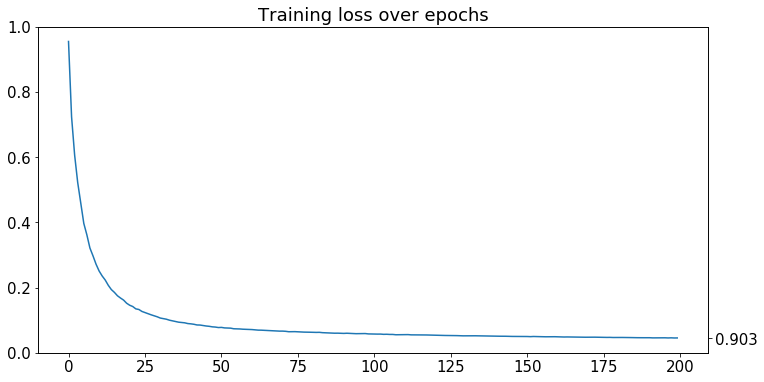

None

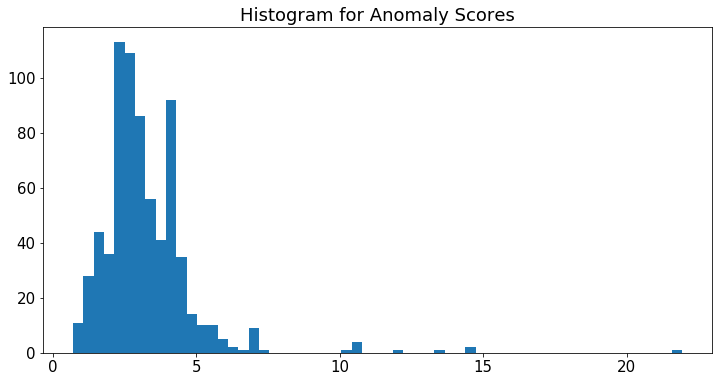

None

In [21]:
# Model 1
display(plot_training_loss(trained_models[0]))
display(plot_decision_function(
    calculate_score=True, model=trained_models[0], data=X_data
))
# print(
#     "Outliers count:",
#     count_outliers(
#         threshold=4, calculate_score=True, model=trained_models[0], data=X_data
#     ),
# )

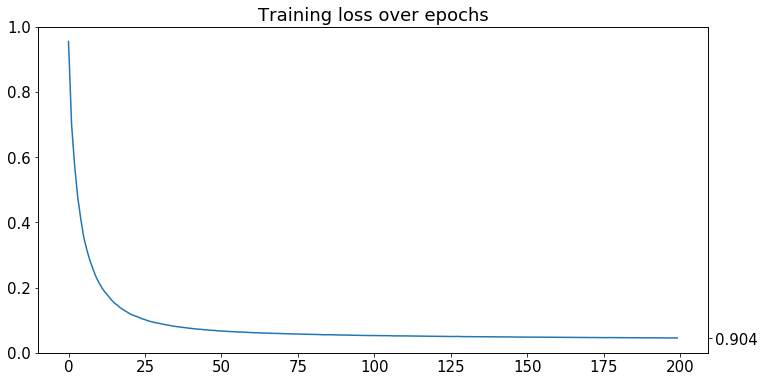

None

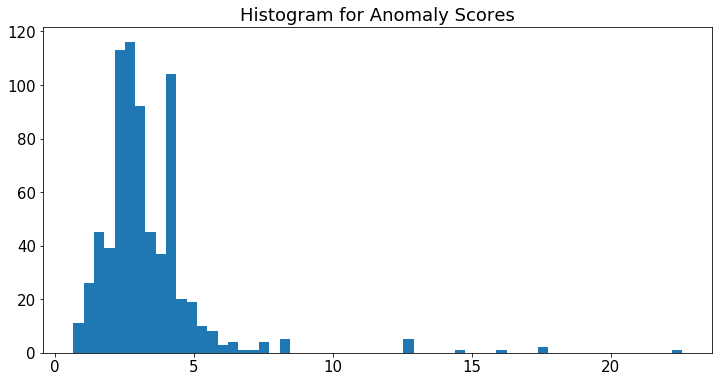

None

In [22]:
# Model 2
display(plot_training_loss(trained_models[1]))
display(plot_decision_function(
    calculate_score=True, model=trained_models[1], data=X_data
))
# print(
#     "Outliers count:",
#     count_outliers(
#         threshold=4, calculate_score=True, model=trained_models[1], data=X_data
#     ),
# )

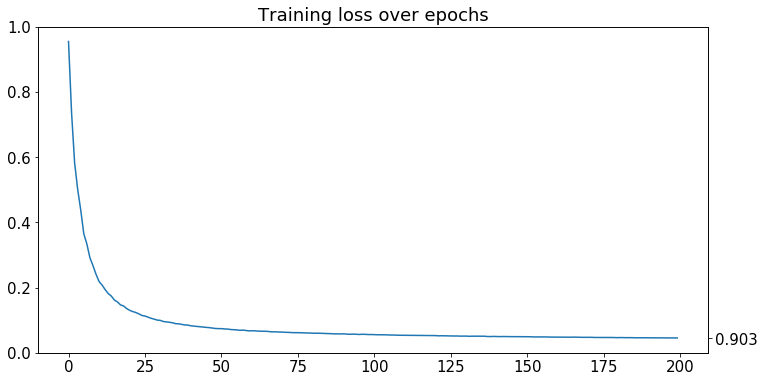

None

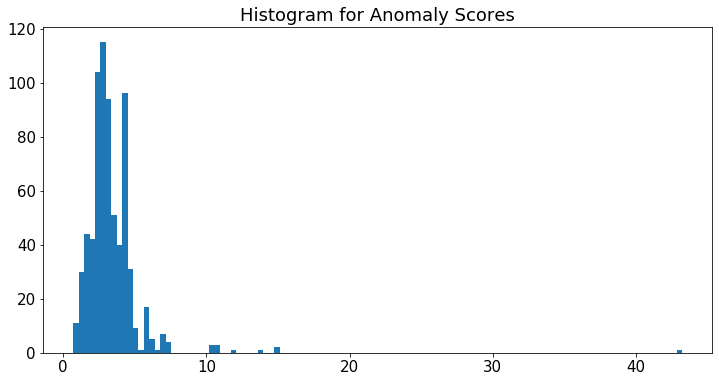

None

In [23]:
# Model 3
display(plot_training_loss(trained_models[2]))
display(plot_decision_function(
    calculate_score=True, model=trained_models[2], data=X_data
))
# print(
#     "Outliers count:",
#     count_outliers(
#         threshold=4, calculate_score=True, model=trained_models[2], data=X_data
#     ),
# )

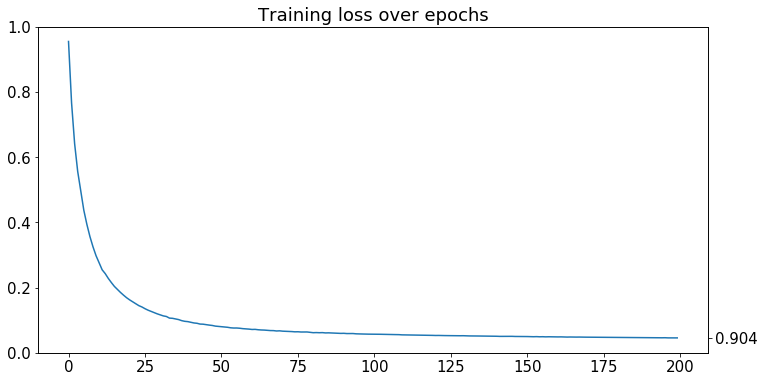

None

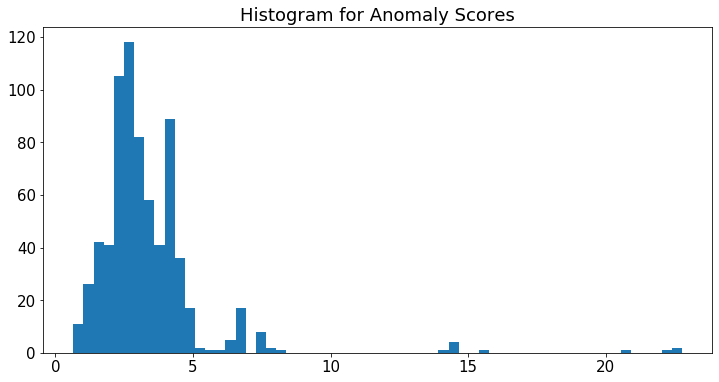

None

In [24]:
# Model 4
display(plot_training_loss(trained_models[3]))
display(plot_decision_function(
    calculate_score=True, model=trained_models[3], data=X_data
))
# print(
#     "Outliers count:",
#     count_outliers(
#         threshold=4, calculate_score=True, model=trained_models[3], data=X_data
#     ),
# )

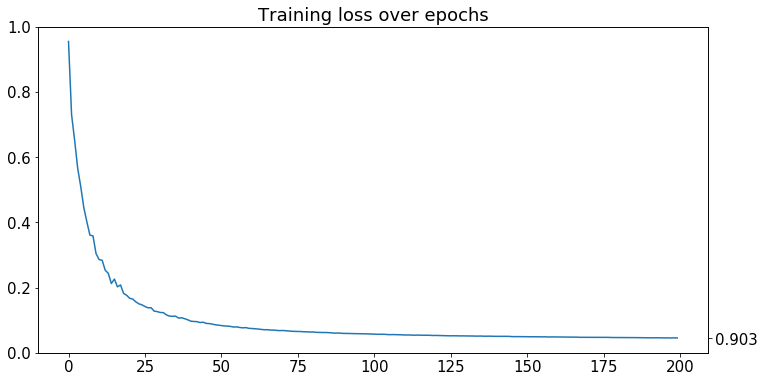

None

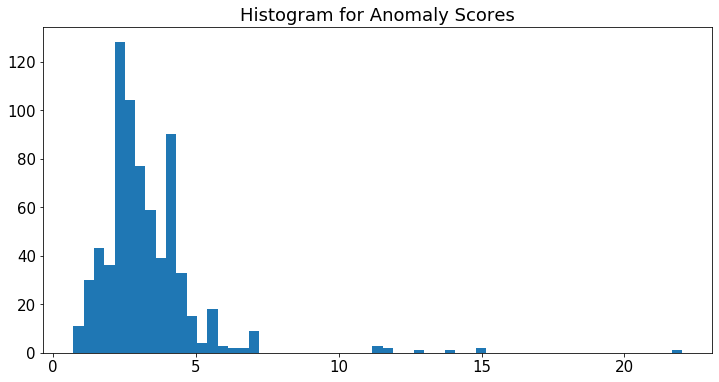

None

In [25]:
# Model 5
display(plot_training_loss(trained_models[4]))
display(plot_decision_function(
    calculate_score=True, model=trained_models[4], data=X_data
))
# print(
#     "Outliers count:",
#     count_outliers(
#         threshold=4, calculate_score=True, model=trained_models[4], data=X_data
#     ),
# )

## Ensembler Class

In [6]:
class AnomallyDetectionEnsembler:
    def __init__(self, *models):
        for model in models:
            if not isinstance(model, AutoEncoder):
                print(type(model))
                raise ValueError("{} is not a AutoEncoder instance".format(type(model)))

        self.models = models

        # fitting and saving a scaler for the prediction scores of the models
        # the scaler will be used to normalize the final decision of the assembler
        decision_scores = pd.DataFrame(
            [
                {"score": score}
                for score in model.decision_scores_
                for model in self.models
            ]
        )
        self.decision_scores_scaler = StandardScaler().fit(decision_scores)

    def predict(self, x, aggregation="avg"):
        """
        aggregation can be avg, max or min
        """
        if aggregation not in ["avg", "max", "min"]:
            raise ValueError("Aggregation must be avg, max or min")

        scores = self.decision_scores_scaler.transform(
            np.array([model.decision_function(x) for model in self.models]).reshape(-1, 1)
        )
        if aggregation == "avg":
            return scores.mean()
        elif aggregation == "max":
            return scores.max()
        else:
            return scores.min()

In [18]:
# instantiate ensemble with trained models
anomally_detection_ensemble_model = AnomallyDetectionEnsembler(*[model for model in trained_models])

In [48]:
# calculate scores
ensemble_model_scores = calculate_ensembler_scores(anomally_detection_ensemble_model, X_data)

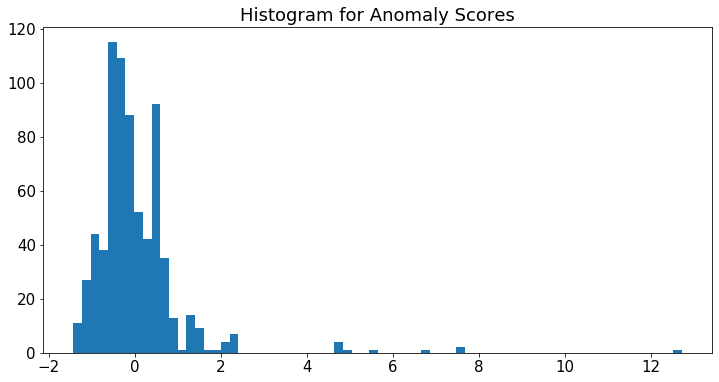

None

In [49]:
# Ensemble model decision function (AVG)
display(plot_decision_function(ensemble_model_scores))

In [ ]:
# Ensemble model decision function (MIN)
display(plot_decision_function(ensemble_model_scores))

In [28]:
# Ensemble model outlier count
count_outliers(3, scores=ensemble_model_scores)

10

In [43]:
results_df = X_data.copy()
results_df["date"] = pd.read_csv("dataset.csv")["date"]
results_df["scores"] = ensemble_model_scores
results_df['is_anomaly'] = np.where(results_df['scores'] > 3, True, False)
display(results_df)

,n_rows,moving_avg_7d_n_rows,null_values_ratio,moving_avg_7d_null_values_ratio,max_string_length,moving_avg_7d_max_string_length,min_string_length,moving_avg_7d_min_string_length,avg_string_length,moving_avg_7d_avg_string_length,max_numeric,moving_avg_7d_max_numeric,min_numeric,moving_avg_7d_min_numeric,avg_numeric,moving_avg_7d_avg_numeric,date,scores,is_anomaly
0,40483,40483.0000,0.4091,0.4091,2894,2894.0000,1,1,35.4610,35.4610,1515413428144,1515413428144.0000,1,1.0000,194009593670.2281,194009593670.2281,2018-01-01,0.4669,False
1,101110,70796.5000,0.4172,0.4131,2902,2898.0000,1,1,35.6261,35.5435,1517500687669,1516457057906.5000,1,1.0000,194058754764.6873,194034174217.4578,2018-01-02,0.5985,False
2,121895,87829.3333,0.4165,0.4143,2894,2896.6667,1,1,35.7299,35.6057,1515765249688,1516226455167.0000,1,1.0000,194083433843.4540,194050594092.7899,2018-01-03,0.5922,False
3,115572,94765.0000,0.4179,0.4152,3152,2960.5000,1,1,35.6451,35.6155,1515268023692,1515986847298.2500,1,1.0000,194092959578.1097,194061185464.1198,2018-01-04,0.5722,False
4,106311,97074.2000,0.4169,0.4155,3149,2998.2000,1,1,35.8557,35.6635,1519491276563,1516687733151.2000,1,1.0000,194113016050.7653,194071551581.4489,2018-01-05,0.5500,False
5,84731,95017.0000,0.4064,0.4140,2844,2972.5000,1,1,34.9761,35.5490,1516476968114,1516652605645.0000,1,1.0000,194118628372.6128,194079397713.3096,2018-01-06,0.4523,False
6,92048,94592.8571,0.4115,0.4136,3213,3006.8571,1,1,34.7605,35.4363,1516559284082,1516639273993.1428,1,1.0000,194140010017.3358,194088056613.8848,2018-01-07,0.4367,False
7,125830,106785.2857,0.4201,0.4152,3213,3052.4286,1,1,35.0782,35.3817,1515624167162,1516669379567.1428,1,1.0000,194168336844.4063,194110734210.1959,2018-01-08,0.5784,False
8,130842,111032.7143,0.4178,0.4153,3182,3092.4286,1,1,35.2295,35.3250,1516947049720,1516590288431.5715,1,1.0000,194199910702.8933,194130899344.2253,2018-01-09,0.5293,False
9,123299,111233.2857,0.4178,0.4155,2940,3099.0000,1,1,35.3534,35.2712,1517503912598,1516838668847.2856,1,1.0000,194214190205.7936,194149578824.5596,2018-01-10,0.5692,False


In [46]:
# only anomalies
display(results_df[results_df["is_anomaly"]])

,n_rows,moving_avg_7d_n_rows,null_values_ratio,moving_avg_7d_null_values_ratio,max_string_length,moving_avg_7d_max_string_length,min_string_length,moving_avg_7d_min_string_length,avg_string_length,moving_avg_7d_avg_string_length,max_numeric,moving_avg_7d_max_numeric,min_numeric,moving_avg_7d_min_numeric,avg_numeric,moving_avg_7d_avg_numeric,date,scores,is_anomaly
51,10023417,1900343.8571,0.4212,0.3946,3209,3006.2857,1,1,36.1636,35.9990,1521618442374,1524603335823.4285,1,1.0000,195004304696.1531,194966192771.6259,2018-02-21,12.7221,True
64,137780,148294.1429,0.3741,0.3800,2998,2982.5714,1,1,35.2957,34.4608,3729494204880,1837468827837.8567,1,1.0000,195297712542.0893,195201603660.0504,2018-03-06,6.7922,True
230,132705,157390.5714,0.3737,0.3783,2974,3046.4286,1,1,38.1455,39.2391,1536513491742,1538177189741.8572,-1,0.7143,198984969582.9807,198919392813.6097,2018-08-19,4.8478,True
343,263252,248021.7143,0.3833,0.3845,3601,3537.8571,1,1,42.5406,41.9412,1546855904846,1546073776523.8572,-1,0.7143,201686552054.1041,201607846216.3711,2018-12-10,4.7102,True
359,289441,194411.7143,0.3847,0.3828,3418,3425.7143,1,1,42.7753,41.7144,3940106507568,1888864274145.7144,1,1.0000,202046976732.8729,201965357718.1490,2018-12-26,7.5134,True
384,284947,338835.7143,0.3761,0.3790,3333,3415.8571,1,1,42.2694,43.0130,1548548561299,1551050984472.5715,-1,0.7143,202581026093.6237,202520883163.1120,2019-01-20,4.7429,True
404,302962,364321.4286,0.3775,0.3844,3564,3533.8571,1,1,43.8910,44.5063,3947537149912,1893915551681.4285,1,1.0000,203114466269.8221,203075388502.2497,2019-02-09,7.5507,True
422,409997,363955.7143,0.3923,0.3889,3468,3495.8571,1,1,58.4771,58.2459,1552066942344,1554928865671.0000,-1,0.7143,203578884270.6917,203504125685.8892,2019-02-27,4.6746,True
423,367119,363731.0000,0.3932,0.3898,3493,3491.1429,1,1,59.6200,58.5414,1555077859905,1554310081992.0000,-1,0.4286,203617892024.2116,203529466620.8902,2019-02-28,5.5701,True
536,514633,513240.7143,0.4058,0.4066,3969,4400.4286,1,1,83.5936,83.0340,1562596230824,1563940374798.0000,-1,0.7143,206444857294.5750,206398802860.8214,2019-06-21,4.8390,True


## Save Model (Pickle)

In [ ]:
# import dill as pickle
# filename ='model_v1.pk'
# with open(filename,'wb')as file:
#     pickle.dump(anomally_detection_ensemble_model, file)

In [ ]:
with open('ensemble_model.pkl', 'wb') as f:
    pickle.dump(anomally_detection_ensemble_model, f, pickle.HIGHEST_PROTOCOL)

# Anomaly Tests

In [7]:
# load model
with open('ensemble_model.pkl', 'rb') as f:
    ensemble_model = pickle.load(f)

### n_rows anomaly

In [54]:
row = X_data.iloc[[500]]
print("anomaly_score = {}, is_anomaly = {}".format(ensemble_model.predict(row), ensemble_model.predict(row) > 3))
row

anomaly_score = -0.47210331071277556, is_anomaly = False


,n_rows,moving_avg_7d_n_rows,null_values_ratio,moving_avg_7d_null_values_ratio,max_string_length,moving_avg_7d_max_string_length,min_string_length,moving_avg_7d_min_string_length,avg_string_length,moving_avg_7d_avg_string_length,max_numeric,moving_avg_7d_max_numeric,min_numeric,moving_avg_7d_min_numeric,avg_numeric,moving_avg_7d_avg_numeric
500,483232,438275.7143,0.4076,0.4063,4010,4035.0000,1,1,81.5131,81.2484,1560638775087,1560190143206.2856,1,1.0000,205578338546.4052,205486385587.7744


In [62]:
# +10x test
row_test = row.copy()
row_test["n_rows"] = row_test["n_rows"] * 10
print("anomaly_score = {}, is_anomaly = {}".format(ensemble_model.predict(row_test), ensemble_model.predict(row_test) > 3))
row_test

anomaly_score = 4.793380326171279, is_anomaly = True


,n_rows,moving_avg_7d_n_rows,null_values_ratio,moving_avg_7d_null_values_ratio,max_string_length,moving_avg_7d_max_string_length,min_string_length,moving_avg_7d_min_string_length,avg_string_length,moving_avg_7d_avg_string_length,max_numeric,moving_avg_7d_max_numeric,min_numeric,moving_avg_7d_min_numeric,avg_numeric,moving_avg_7d_avg_numeric
500,4832320,438275.7143,0.4076,0.4063,4010,4035.0000,1,1,81.5131,81.2484,1560638775087,1560190143206.2856,1,1.0000,205578338546.4052,205486385587.7744


In [63]:
# -10x test
row_test = row.copy()
row_test["n_rows"] = row_test["n_rows"] / 10
print("anomaly_score = {}, is_anomaly = {}".format(ensemble_model.predict(row_test), ensemble_model.predict(row_test) > 3))
row_test

anomaly_score = -0.4111198694027096, is_anomaly = False


,n_rows,moving_avg_7d_n_rows,null_values_ratio,moving_avg_7d_null_values_ratio,max_string_length,moving_avg_7d_max_string_length,min_string_length,moving_avg_7d_min_string_length,avg_string_length,moving_avg_7d_avg_string_length,max_numeric,moving_avg_7d_max_numeric,min_numeric,moving_avg_7d_min_numeric,avg_numeric,moving_avg_7d_avg_numeric
500,48323.2000,438275.7143,0.4076,0.4063,4010,4035.0000,1,1,81.5131,81.2484,1560638775087,1560190143206.2856,1,1.0000,205578338546.4052,205486385587.7744


### nulls_ratio anomaly

In [64]:
row = X_data.iloc[[710]]
print("anomaly_score = {}, is_anomaly = {}".format(ensemble_model.predict(row), ensemble_model.predict(row) > 3))
row

anomaly_score = 0.9229681475457273, is_anomaly = False


,n_rows,moving_avg_7d_n_rows,null_values_ratio,moving_avg_7d_null_values_ratio,max_string_length,moving_avg_7d_max_string_length,min_string_length,moving_avg_7d_min_string_length,avg_string_length,moving_avg_7d_avg_string_length,max_numeric,moving_avg_7d_max_numeric,min_numeric,moving_avg_7d_min_numeric,avg_numeric,moving_avg_7d_avg_numeric
710,612548,613974.5714,0.3857,0.3847,5415,5217.7143,1,1,103.9520,104.2427,1578845562374,1591744222142.2856,1,1.0000,210992734901.5295,210816470793.6534


In [68]:
row_test = row.copy()
row_test["null_values_ratio"] = row_test["null_values_ratio"] * 2
print("anomaly_score = {}, is_anomaly = {}".format(ensemble_model.predict(row_test), ensemble_model.predict(row_test) > 3))
row_test

anomaly_score = 13.174625561911366, is_anomaly = True


,n_rows,moving_avg_7d_n_rows,null_values_ratio,moving_avg_7d_null_values_ratio,max_string_length,moving_avg_7d_max_string_length,min_string_length,moving_avg_7d_min_string_length,avg_string_length,moving_avg_7d_avg_string_length,max_numeric,moving_avg_7d_max_numeric,min_numeric,moving_avg_7d_min_numeric,avg_numeric,moving_avg_7d_avg_numeric
710,612548,613974.5714,0.7713,0.3847,5415,5217.7143,1,1,103.9520,104.2427,1578845562374,1591744222142.2856,1,1.0000,210992734901.5295,210816470793.6534


### int overflow

In [70]:
row = X_data.iloc[[705]]
print("anomaly_score = {}, is_anomaly = {}".format(ensemble_model.predict(row), ensemble_model.predict(row) > 3))
row

anomaly_score = 0.8575571504087808, is_anomaly = False


,n_rows,moving_avg_7d_n_rows,null_values_ratio,moving_avg_7d_null_values_ratio,max_string_length,moving_avg_7d_max_string_length,min_string_length,moving_avg_7d_min_string_length,avg_string_length,moving_avg_7d_avg_string_length,max_numeric,moving_avg_7d_max_numeric,min_numeric,moving_avg_7d_min_numeric,avg_numeric,moving_avg_7d_avg_numeric
705,525336,613194.5714,0.3820,0.3850,5164,5405.0000,1,1,103.2033,102.8160,1580391998463,1578461647923.8572,1,1.0000,210704709284.3864,210654672727.8249


In [71]:
row_test = row.copy()
row_test["min_numeric"] = -2147483648
print("anomaly_score = {}, is_anomaly = {}".format(ensemble_model.predict(row_test), ensemble_model.predict(row_test) > 3))
row_test

anomaly_score = 6639280077.672033, is_anomaly = True


,n_rows,moving_avg_7d_n_rows,null_values_ratio,moving_avg_7d_null_values_ratio,max_string_length,moving_avg_7d_max_string_length,min_string_length,moving_avg_7d_min_string_length,avg_string_length,moving_avg_7d_avg_string_length,max_numeric,moving_avg_7d_max_numeric,min_numeric,moving_avg_7d_min_numeric,avg_numeric,moving_avg_7d_avg_numeric
705,525336,613194.5714,0.3820,0.3850,5164,5405.0000,1,1,103.2033,102.8160,1580391998463,1578461647923.8572,-2147483648,1.0000,210704709284.3864,210654672727.8249


### avg_string_length anomaly

In [72]:
row = X_data.iloc[[550]]
print("anomaly_score = {}, is_anomaly = {}".format(ensemble_model.predict(row), ensemble_model.predict(row) > 3))
row

anomaly_score = -0.20892545728398018, is_anomaly = False


,n_rows,moving_avg_7d_n_rows,null_values_ratio,moving_avg_7d_null_values_ratio,max_string_length,moving_avg_7d_max_string_length,min_string_length,moving_avg_7d_min_string_length,avg_string_length,moving_avg_7d_avg_string_length,max_numeric,moving_avg_7d_max_numeric,min_numeric,moving_avg_7d_min_numeric,avg_numeric,moving_avg_7d_avg_numeric
550,498183,536597.8571,0.4066,0.4044,4283,4452.4286,1,1,84.8293,84.1811,1565406477620,1564836232313.8572,1,1.0000,206837206993.4389,206716459767.7144


In [93]:
# +10x test
row_test = row.copy()
row_test["avg_string_length"] = row_test["avg_string_length"] * 10
# row_test["moving_avg_7d_avg_string_length"] = row_test["moving_avg_7d_avg_string_length"] / 5
print("anomaly_score = {}, is_anomaly = {}".format(ensemble_model.predict(row_test), ensemble_model.predict(row_test) > 3))
row_test

anomaly_score = 16.16103147535977, is_anomaly = True


,n_rows,moving_avg_7d_n_rows,null_values_ratio,moving_avg_7d_null_values_ratio,max_string_length,moving_avg_7d_max_string_length,min_string_length,moving_avg_7d_min_string_length,avg_string_length,moving_avg_7d_avg_string_length,max_numeric,moving_avg_7d_max_numeric,min_numeric,moving_avg_7d_min_numeric,avg_numeric,moving_avg_7d_avg_numeric
550,498183,536597.8571,0.4066,0.4044,4283,4452.4286,1,1,848.2928,84.1811,1565406477620,1564836232313.8572,1,1.0000,206837206993.4389,206716459767.7144


In [104]:
# -10x test
row_test = row.copy()
row_test["avg_string_length"] = row_test["avg_string_length"] / 10
print("anomaly_score = {}, is_anomaly = {}".format(ensemble_model.predict(row_test), ensemble_model.predict(row_test) > 3))
row_test

anomaly_score = 0.08495668105902861, is_anomaly = False


,n_rows,moving_avg_7d_n_rows,null_values_ratio,moving_avg_7d_null_values_ratio,max_string_length,moving_avg_7d_max_string_length,min_string_length,moving_avg_7d_min_string_length,avg_string_length,moving_avg_7d_avg_string_length,max_numeric,moving_avg_7d_max_numeric,min_numeric,moving_avg_7d_min_numeric,avg_numeric,moving_avg_7d_avg_numeric
550,498183,536597.8571,0.4066,0.4044,4283,4452.4286,1,1,8.4829,84.1811,1565406477620,1564836232313.8572,1,1.0000,206837206993.4389,206716459767.7144
